In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
from os import listdir
from os.path import exists

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
from sklearn.cluster import KMeans
from sklearn import manifold, decomposition
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, classification_report

In [3]:
import cv2

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [5]:
path_csv = './data/Flipkart/flipkart_com-ecommerce_sample_1050.csv'
path_img = './data/Flipkart/Images'
path_img_little = './data/Flipkart/ImagesLittles'

In [6]:
data = pd.read_csv(path_csv)

In [7]:
# Récupère le noeud à la profondeur level
# (ou la feuille si level va trop profond)
def get_from_tree(tree, level):
    if len(tree) > level:
        return tree[level]
    else:
        return tree[-1]

In [8]:
data['product_category_list'] = data['product_category_tree'].apply(lambda e : e[2:-2]).str.split(' >> ')

In [9]:
def show_representation(data, cat, limit=None, X_tsne=None, title=''):
    if X_tsne is None:
        tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random')
        X_tsne = tsne.fit_transform(data)
    
    df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
    df_tsne["class"] = cat.reset_index(drop=True)
    
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x="tsne1", y="tsne2",
        hue="class",
        palette=sns.color_palette('tab10', n_colors=nb_cat_little), s=50,
        data=df_tsne,
        legend="brief")

    plt.title(title, fontsize = 14, pad = 35, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 14, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 14, fontweight = 'bold')
    plt.legend(prop={'size': 8}) 

    plt.show()
    
    return X_tsne

In [10]:
level = -2

In [11]:
nb_min_elements = 2

In [12]:
data_final = data[['image', 'product_category_list']].copy()
data_final.columns = ['img', 'cat_lst']
data_final['img'] = path_img+'/'+data_final['img']

data_final['cat'] = data_final['cat_lst'].apply(lambda tree : get_from_tree(tree, level))

list_labels = list(data_final['cat'].value_counts().index)
data_final['label'] = data_final['cat'].apply(lambda e : list_labels.index(e))

In [13]:
nb_cat_little = (data_final['cat'].value_counts() > nb_min_elements).sum()
nb_cat = len(list_labels)

In [14]:
print("Nombre de catégories total :", nb_cat)
print("Nombre de catégories de plus de", nb_min_elements, "élément :", nb_cat_little)

Nombre de catégories total : 299
Nombre de catégories de plus de 2 élément : 46


In [15]:
data_little = data_final.loc[data_final['cat'].isin(list_labels[:nb_cat_little])].copy().reset_index()

In [16]:
data_little

,index,img,cat_lst,cat,label
0,0,./data/Flipkart/Images/55b85ea15a1536d46b7190a...,"[Home Furnishing, Curtains & Accessories, Curt...",Curtains,17
1,5,./data/Flipkart/Images/893aa5ed55f7cff2eccea77...,"[Watches, Wrist Watches, Maserati Time Wrist W...",Wrist Watches,0
2,6,./data/Flipkart/Images/f355cc1ccb08bd0d283ed97...,"[Watches, Wrist Watches, Camerii Wrist Watches]",Wrist Watches,0
3,7,./data/Flipkart/Images/dd0e3470a7e6ed76fd69c2d...,"[Watches, Wrist Watches, T STAR Wrist Watches]",Wrist Watches,0
4,8,./data/Flipkart/Images/41384da51732c0b4df3de8f...,"[Watches, Wrist Watches, Alfajr Wrist Watches]",Wrist Watches,0
...,...,...,...,...,...
762,1045,./data/Flipkart/Images/958f54f4c46b53c8a0a9b81...,"[Baby Care, Baby & Kids Gifts, Stickers, Oren ...",Stickers,18
763,1046,./data/Flipkart/Images/fd6cbcc22efb6b761bd564c...,"[Baby Care, Baby & Kids Gifts, Stickers, Wallm...",Stickers,18
764,1047,./data/Flipkart/Images/5912e037d12774bb73a2048...,"[Baby Care, Baby & Kids Gifts, Stickers, Uberl...",Stickers,18
765,1048,./data/Flipkart/Images/c3edc504d1b4f0ba6224fa5...,"[Baby Care, Baby & Kids Gifts, Stickers, Wallm...",Stickers,18


# Mon CODE

In [17]:
input_shape = VGG16().input_shape
input_shape

(None, 224, 224, 3)

In [18]:
base_model = VGG16(include_top=False, input_shape=input_shape[1:])
base_model.trainable = False

In [19]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Conversion

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
from tensorflow.keras.utils import to_categorical

In [22]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
def preprocess_image(path):
    image = load_img(path, target_size=input_shape[1:3])
    image = img_to_array(image)
    image = preprocess_input(image)
    return image

In [24]:
def cat_to_label(l):
    return np.argmax(l)

In [25]:
data_X = list(data_little["img"].apply(preprocess_image))
data_X = np.asarray(data_X).astype(np.float32)

C:\ProgramData\Anaconda3\envs\Tensorflow\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [26]:
data_y = to_categorical(data_little['label'], num_classes=nb_cat_little)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.33, stratify=data_y)

In [28]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(nb_cat_little*10, activation='relu')
drop_out = layers.Dropout(0.2)
dense_layer_2 = layers.Dense(nb_cat_little*4, activation='relu')
prediction_layer = layers.Dense(nb_cat_little, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    drop_out,
    dense_layer_2,
    prediction_layer
])

# Dropout(0.5)(x)

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 460)               11540940  
                                                                 
 dropout (Dropout)           (None, 460)               0         
                                                                 
 dense_1 (Dense)             (None, 184)               84824     
                                                                 
 dense_2 (Dense)             (None, 46)                8510      
                                                                 
Total params: 26,348,962
Trainable params: 11,634,274
No

In [30]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy',  min_delta = 0.02, mode='max', patience=3, restore_best_weights=True)
es = EarlyStopping(monitor='val_loss', min_delta = 0.02, mode='min', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/20
13/13 [==============================] - 196s 15s/step - loss: 22.3951 - accuracy: 0.4024 - val_loss: 10.0321 - val_accuracy: 0.5631
Epoch 2/20
13/13 [==============================] - 189s 15s/step - loss: 3.8200 - accuracy: 0.7951 - val_loss: 7.6074 - val_accuracy: 0.6408
Epoch 3/20
13/13 [==============================] - 192s 15s/step - loss: 1.5316 - accuracy: 0.9000 - val_loss: 8.6258 - val_accuracy: 0.6893
Epoch 4/20
13/13 [==============================] - 193s 15s/step - loss: 0.7925 - accuracy: 0.9439 - val_loss: 10.2499 - val_accuracy: 0.6699
Epoch 5/20
13/13 [==============================] - 193s 15s/step - loss: 0.5198 - accuracy: 0.9659 - val_loss: 7.5599 - val_accuracy: 0.6893
Epoch 6/20
13/13 [==============================] - 192s 15s/step - loss: 0.5022 - accuracy: 0.9732 - val_loss: 7.6418 - val_accuracy: 0.6990
Epoch 7/20
13/13 [==============================] - 192s 15s/step - loss: 0.3172 - accuracy: 0.9756 - val_loss: 8.6883 - val_accuracy: 0.6990
Epo

In [31]:
pred_train = model.predict(X_train)

17/17 [==============================] - 192s 11s/step


In [32]:
balanced_accuracy_score([cat_to_label(e) for e in pred_train], [cat_to_label(e) for e in y_train])

0.9543758626639061

In [33]:
labels_little = data_little.sort_values('label')['cat'].drop_duplicates().to_list()

In [34]:
print(classification_report(
    [cat_to_label(e) for e in y_train],
    [cat_to_label(e) for e in pred_train],
    target_names=labels_little,
    zero_division=0))

                                          precision    recall  f1-score   support

                           Wrist Watches       1.00      1.00      1.00        93
                                  Combos       0.96      1.00      0.98        43
                             Coffee Mugs       1.00      1.00      1.00        42
                               Bed Linen       0.82      0.93      0.87        40
                                 Routers       0.97      0.97      0.97        32
                              Showpieces       0.95      0.87      0.91        23
                             USB Gadgets       0.96      1.00      0.98        23
                                  Ethnic       1.00      0.96      0.98        23
                               Batteries       1.00      1.00      1.00        15
                          Woks & Kadhais       1.00      1.00      1.00        15
                              Bath Linen       1.00      0.69      0.82        13
               

In [35]:
pred_test = model.predict(X_test)

8/8 [==============================] - 95s 12s/step


In [36]:
balanced_accuracy_score([cat_to_label(e) for e in y_test], [cat_to_label(e) for e in pred_test])

0.595894504046678

In [37]:
print(classification_report(
    [cat_to_label(e) for e in y_test],
    [cat_to_label(e) for e in pred_test],
    target_names=labels_little,
    zero_division=0))

                                          precision    recall  f1-score   support

                           Wrist Watches       1.00      1.00      1.00        47
                                  Combos       1.00      0.95      0.98        21
                             Coffee Mugs       0.91      1.00      0.95        21
                               Bed Linen       0.62      0.75      0.68        20
                                 Routers       0.70      0.88      0.78        16
                              Showpieces       0.50      0.17      0.25        12
                             USB Gadgets       0.50      0.45      0.48        11
                                  Ethnic       0.47      0.64      0.54        11
                               Batteries       1.00      1.00      1.00         7
                          Woks & Kadhais       0.78      1.00      0.88         7
                              Bath Linen       0.50      0.14      0.22         7
               

In [38]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

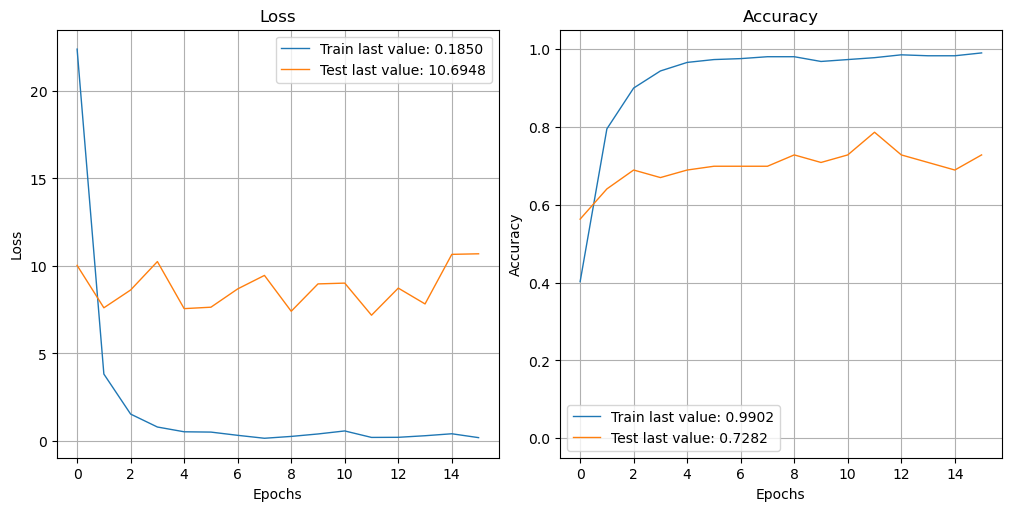

In [39]:
show_history(history)
#plot_history(history, path="standard.png")
plt.close()

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

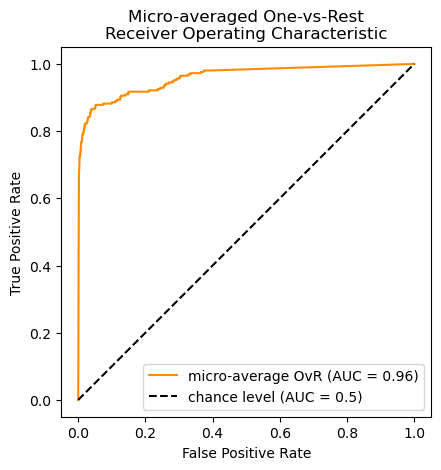

In [41]:
RocCurveDisplay.from_predictions(
    y_test.ravel(),
    pred_test.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [42]:
@interact
def show_ROC_mono(class_of_interest = labels_little):
    class_id = labels_little.index(class_of_interest)
    RocCurveDisplay.from_predictions(
        y_test[:, class_id],
        pred_test[:, class_id],
        name=f"{class_of_interest} vs the rest",
        color="darkorange",
    )

    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{class_of_interest} vs Rest ROC curves")
    plt.legend()
    return plt.show()

interactive(children=(Dropdown(description='class_of_interest', options=('Wrist Watches', 'Combos', 'Coffee Mu…

# Data Augmentation

In [43]:
tmp = data_final['cat'].value_counts()

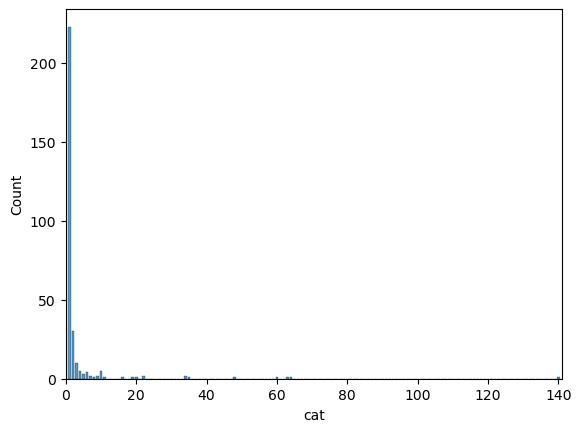

In [44]:
fig, ax = plt.subplots()
sns.histplot(tmp, shrink=.8, discrete=True, ax=ax)
ax.set_xlim(0,max(tmp)+1)
plt.show()

In [45]:
def show_from_cv2(img):
    plt.figure(figsize=(6, 6))
    
    plt.imshow(img)
    
    ax = plt.gca()
    plt.axis("off")
    return plt.show()

In [46]:
path = data_little['img'].iloc[0]

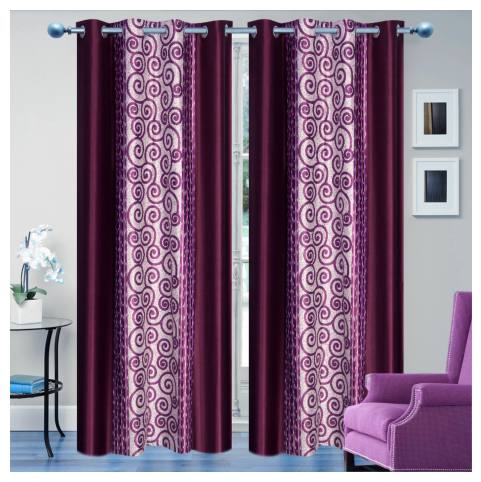

In [47]:
img = cv2.imread(path)
img = cv2.resize(img, dsize=(1000, 1000), interpolation=cv2.INTER_CUBIC)
show_from_cv2(img)

In [48]:
@interact
def change_hue(new=widgets.IntSlider(min=0, max=360, step=1, value=0)):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    hnew = np.mod(h + new, 180).astype(h.dtype)
    hsv_new = cv2.merge([hnew,s,v])
    img_new = cv2.cvtColor(hsv_new, cv2.COLOR_HSV2RGB)
    return show_from_cv2(img_new)

interactive(children=(IntSlider(value=0, description='new', max=360), Output()), _dom_classes=('widget-interac…

In [49]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.axis("off")
 
    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.axis("off")

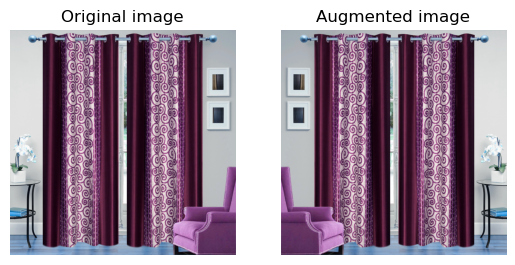

In [50]:
flipped = tf.image.flip_left_right(img)
visualize(img, flipped)

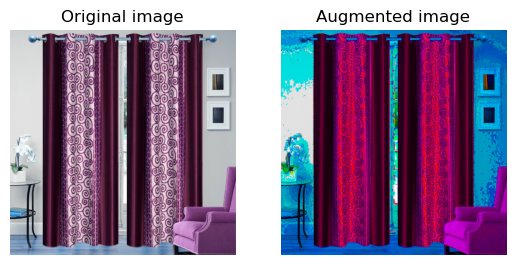

In [51]:
saturated = tf.image.adjust_saturation(img, 256)
visualize(img, saturated)

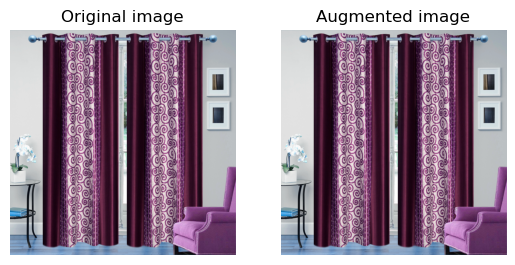

In [52]:
tmp = tf.image.adjust_brightness(img, 0)
visualize(img, tmp)

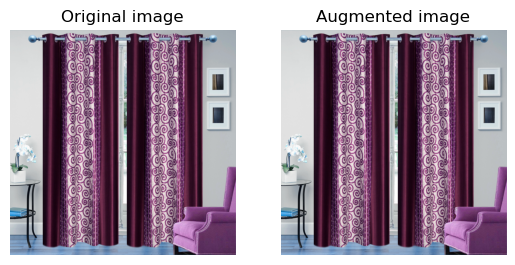

In [53]:
tmp = tf.image.adjust_contrast(img, 1)
visualize(img, tmp)

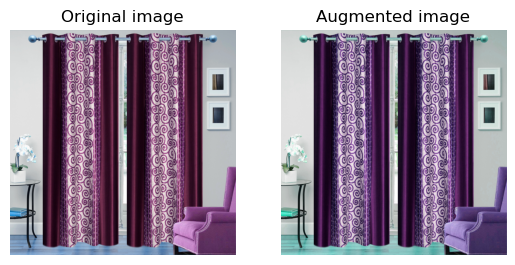

In [54]:
tmp = tf.image.adjust_hue(img, -0.1)
visualize(img, tmp)

In [55]:
i = 1

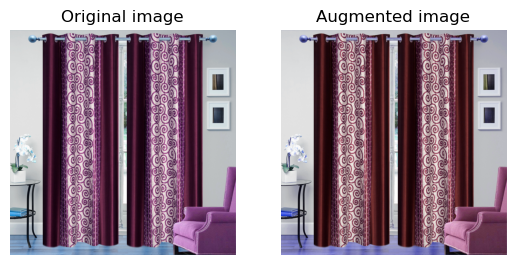

In [56]:
bright = tf.image.stateless_random_hue(img, 0.1, (i, 0))
visualize(img, bright)
i += 1

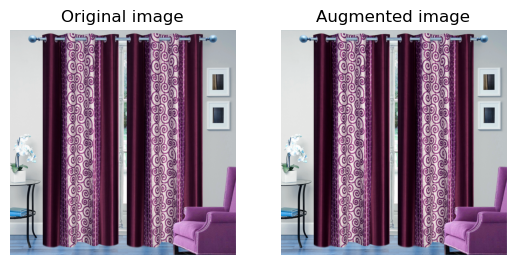

In [57]:
bright = tf.image.stateless_random_contrast(img, 1, 1.1, (0, 2))
visualize(img, bright)

In [58]:
import albumentations as A

In [59]:
transform = A.Compose([
    #A.RandomCrop(width=256, height=256, p=1),
    #A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    #A.CLAHE(),
    #A.RandomRotate90(),
    #A.Transpose(),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.02, rotate_limit=0.02, p=.75, border_mode=cv2.BORDER_REPLICATE),
    A.Blur(blur_limit=3),
    #A.OpticalDistortion(),
    #A.RandomSnow(),
    #A.RandomShadow(),
    A.OneOf([
        A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5),
        A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=5, val_shift_limit=5, p=0.5),
    ]),
    A.RandomBrightnessContrast(p=.75),
    #A.augmentations.geometric.resize.LongestMaxSize(max(input_shape[1:3])),
])

In [60]:
image = cv2.imread(data_little['img'].iloc[0])

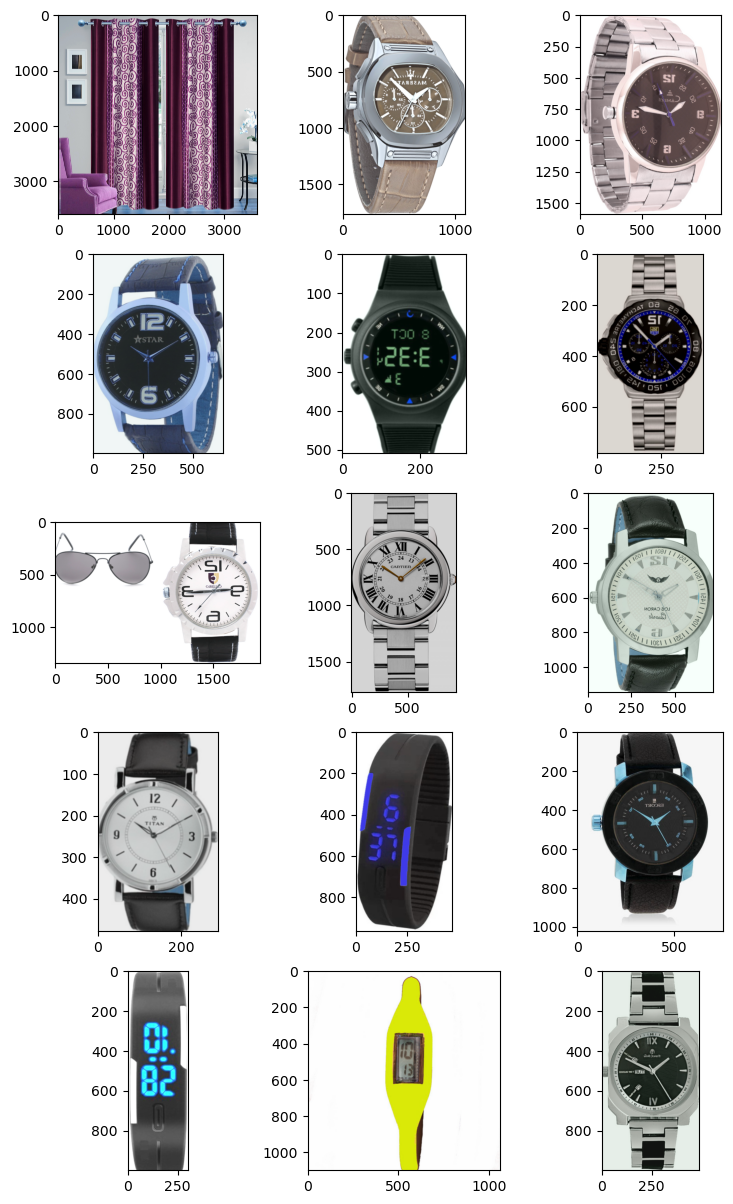

In [61]:
fig, ax = plt.subplots(5, 3, figsize=(9, 15))
for i in range(15):
    transformed = transform(image=cv2.imread(data_little['img'].iloc[i]))
    ax[i // 3, i % 3].imshow(transformed["image"])
plt.show()

In [62]:
def preprocess_image_augmented(path):
    image = load_img(path, target_size=input_shape[1:3])
    image = np.array(image)
    image = transform(image=image)['image']
    image = preprocess_input(image)
    return image

In [63]:
X_train_img, X_test_img, y_train_label, y_test_label = train_test_split(
    data_little['img'],
    data_little['label'],
    test_size=0.33,
    stratify=data_little['label'])

In [64]:
X_test = list(X_test_img.apply(preprocess_image))
X_test = np.asarray(X_test).astype(np.float32)

In [65]:
y_test = to_categorical(y_test_label, num_classes=nb_cat_little)

In [66]:
df = pd.DataFrame([X_train_img, y_train_label]).T
df

,img,label
341,./data/Flipkart/Images/32f24a4303050f500dec7cb...,22
150,./data/Flipkart/Images/de29bf3288345e23b0e2534...,5
89,./data/Flipkart/Images/1afa5f2c3c9b4b43def6dc2...,2
694,./data/Flipkart/Images/a618354ba17cff64826558d...,31
274,./data/Flipkart/Images/4b0e6f200426b1db8824b2c...,1
...,...,...
436,./data/Flipkart/Images/3693c4e7f7efb47edb3d9ee...,0
733,./data/Flipkart/Images/42770faa04bfcf2b62e7ef3...,33
57,./data/Flipkart/Images/c7fcd0d983a51283e58b806...,12
59,./data/Flipkart/Images/336fc49639a5cc45aa532ac...,3


In [67]:
df['label'].value_counts()

0     93
1     43
2     42
3     40
4     32
7     23
6     23
5     23
8     15
9     15
10    13
11    13
12    11
13     7
17     7
18     7
16     7
15     7
14     7
20     6
19     6
21     5
23     5
22     5
26     4
24     4
27     4
25     4
35     3
34     3
29     3
33     3
28     3
30     3
42     2
45     2
39     2
31     2
40     2
43     2
44     2
36     2
32     2
41     2
38     2
37     2
Name: label, dtype: int64

In [68]:
X_augmented = []
y_augmented = []

but = 15
for i, n in df['label'].value_counts().items():
    if n >= but:
        continue
    
    a_faire = but - n
    liste_images = df.loc[df['label']==i, 'img']
    
    for path in np.random.choice(liste_images, a_faire):
        img_tmp = preprocess_image_augmented(path)
        X_augmented.append(img_tmp)
        y_augmented.append(i)

X_augmented = np.asarray(X_augmented).astype(np.float32)

C:\ProgramData\Anaconda3\envs\Tensorflow\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
X_full_augmented = df["img"].apply(preprocess_image_augmented)
X_full_augmented = np.asarray(list(X_full_augmented)).astype(np.float32)

In [ ]:
y_full_augmented = df["label"].copy()

In [ ]:
#X_full_augmented = []
#y_full_augmented = []

In [69]:
X_train = df["img"].apply(preprocess_image)

In [70]:
X_train = np.asarray(list(X_train)).astype(np.float32)

In [71]:
X_train.shape

(513, 224, 224, 3)

In [72]:
X_train = np.concatenate((X_train, X_augmented, X_full_augmented))

In [73]:
X_train.shape

(1688, 224, 224, 3)

In [74]:
len(df["label"])

513

In [75]:
y_train = np.concatenate((df["label"], y_augmented, y_full_augmented))

In [76]:
y_train.shape

(1688,)

In [77]:
y_train = to_categorical(y_train, num_classes=nb_cat_little)

In [78]:
y_train.shape

(1688, 46)

In [79]:
base_model = VGG16(include_top=False, input_shape=input_shape[1:])
base_model.trainable = False

In [80]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(nb_cat_little*10, activation='relu')
drop_out = layers.Dropout(0.2)
dense_layer_2 = layers.Dense(nb_cat_little*4, activation='relu')
prediction_layer = layers.Dense(nb_cat_little, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    drop_out,
    dense_layer_2,
    prediction_layer
])

# Dropout(0.5)(x)

In [81]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy',  min_delta = 0.02, mode='max', patience=3, restore_best_weights=True)
es = EarlyStopping(monitor='val_loss', min_delta = 0.02, mode='min', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, validation_split=0.3, batch_size=32, callbacks=[es])

Epoch 1/20
37/37 [==============================] - 634s 17s/step - loss: 10.6656 - accuracy: 0.6376 - val_loss: 7.1320 - val_accuracy: 0.4359
Epoch 2/20
37/37 [==============================] - 638s 17s/step - loss: 1.1126 - accuracy: 0.9238 - val_loss: 4.2916 - val_accuracy: 0.5937
Epoch 3/20
37/37 [==============================] - 621s 17s/step - loss: 0.6694 - accuracy: 0.9526 - val_loss: 6.0055 - val_accuracy: 0.7002
Epoch 4/20
37/37 [==============================] - 609s 17s/step - loss: 0.7234 - accuracy: 0.9627 - val_loss: 3.4072 - val_accuracy: 0.7278
Epoch 5/20
37/37 [==============================] - 609s 17s/step - loss: 0.3814 - accuracy: 0.9738 - val_loss: 2.1729 - val_accuracy: 0.8146
Epoch 6/20
37/37 [==============================] - 608s 17s/step - loss: 0.6335 - accuracy: 0.9704 - val_loss: 6.5935 - val_accuracy: 0.6982
Epoch 7/20
37/37 [==============================] - 600s 16s/step - loss: 0.2932 - accuracy: 0.9839 - val_loss: 6.5503 - val_accuracy: 0.7613
Epoch

In [82]:
pred_train = model.predict(X_train)

53/53 [==============================] - 607s 11s/step


In [83]:
balanced_accuracy_score([cat_to_label(e) for e in pred_train], [cat_to_label(e) for e in y_train])

0.9507001498920836

In [84]:
labels_little = data_little.sort_values('label')['cat'].drop_duplicates().to_list()

In [85]:
print(classification_report(
    [cat_to_label(e) for e in y_train],
    [cat_to_label(e) for e in pred_train],
    target_names=labels_little,
    zero_division=0))

                                          precision    recall  f1-score   support

                           Wrist Watches       0.97      1.00      0.98        93
                                  Combos       1.00      1.00      1.00        43
                             Coffee Mugs       0.95      1.00      0.98        42
                               Bed Linen       0.77      1.00      0.87        40
                                 Routers       0.97      1.00      0.99        35
                              Showpieces       1.00      0.94      0.97        35
                             USB Gadgets       0.88      1.00      0.93        35
                                  Ethnic       1.00      1.00      1.00        35
                               Batteries       1.00      0.91      0.96        35
                          Woks & Kadhais       1.00      1.00      1.00        35
                              Bath Linen       0.65      1.00      0.79        35
               

In [86]:
pred_test = model.predict(X_test)

8/8 [==============================] - 91s 11s/step


In [87]:
balanced_accuracy_score([cat_to_label(e) for e in y_test], [cat_to_label(e) for e in pred_test])

0.5395007628818915

In [88]:
print(classification_report(
    [cat_to_label(e) for e in y_test],
    [cat_to_label(e) for e in pred_test],
    target_names=labels_little,
    zero_division=0))

                                          precision    recall  f1-score   support

                           Wrist Watches       0.85      0.98      0.91        47
                                  Combos       0.95      1.00      0.98        21
                             Coffee Mugs       1.00      1.00      1.00        21
                               Bed Linen       0.82      0.90      0.86        20
                                 Routers       0.71      0.75      0.73        16
                              Showpieces       0.42      0.42      0.42        12
                             USB Gadgets       0.83      0.45      0.59        11
                                  Ethnic       0.50      0.09      0.15        11
                               Batteries       1.00      0.71      0.83         7
                          Woks & Kadhais       1.00      0.86      0.92         7
                              Bath Linen       0.44      0.57      0.50         7
               

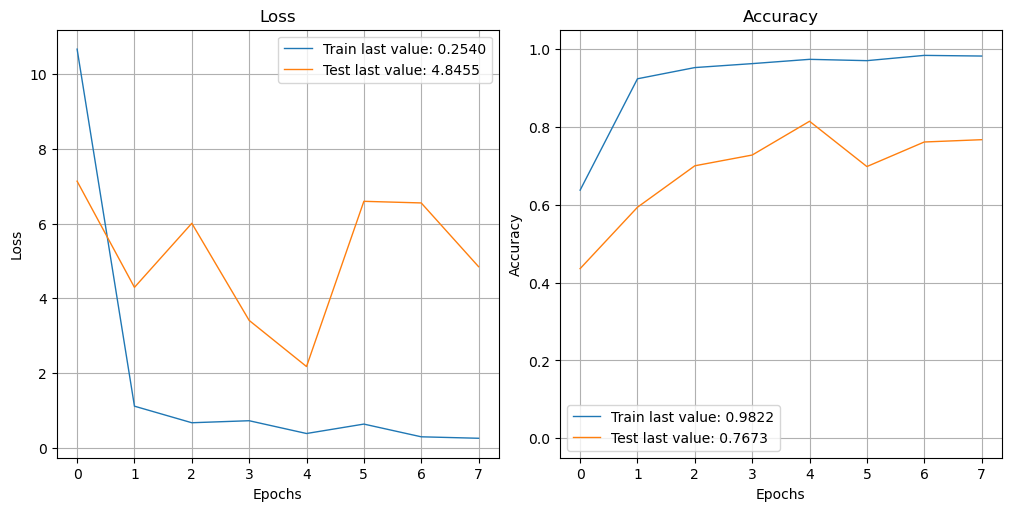

In [89]:
show_history(history)
#plot_history(history, path="standard.png")
plt.close()

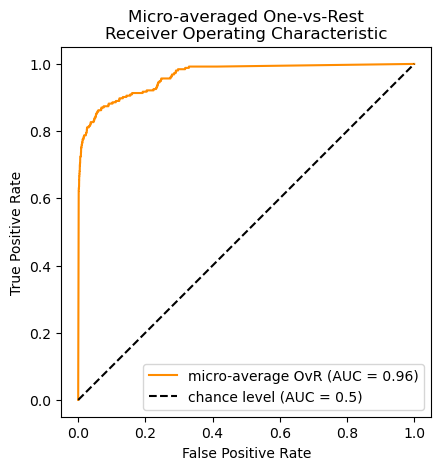

In [90]:
RocCurveDisplay.from_predictions(
    y_test.ravel(),
    pred_test.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()